In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

import skimage
import skimage.io as io
from skimage.feature import hog
from skimage.transform import resize

import sklearn
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier

In [2]:
print(sklearn.__version__)
print(skimage.__version__)

0.21.3
0.15.0


# Load data

In [3]:
# set random seed for reproducable result
RANDOM_SEED = 1612348362
np.random.seed(seed=RANDOM_SEED)

In [4]:
DATA_DIR = './dataset/'
IMG_DIR = os.path.join(DATA_DIR, 'logos')

if not os.path.exists('./images'):
    os.mkdir('./images') # create dir to store plot figures

In [5]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'origin_train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'origin_val.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'origin_test.csv'))

Xem thông tin tập huấn luyện

In [6]:
train_df.head()

,File name,Company
0,logo_1375.jpg,vinamilk
1,logo_965.png,viettel
2,logo_560.jpg,tgdd
3,logo_1070.jpg,vinamilk
4,logo_1145.png,vinamilk


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 2 columns):
File name    189 non-null object
Company      189 non-null object
dtypes: object(2)
memory usage: 3.1+ KB


In [8]:
train_df.describe()

,File name,Company
count,189,189
unique,189,5
top,logo_770.jpg,vinamilk
freq,1,61


Nối đường dẫn đến tên hình file ảnh: Ở đây khai báo một lớp `LoadImage` kế thừa từ `BaseEstimator` và `TransformerMixin` để có các phương thức `fit`, `transform` và để visualize sample bên dưới. Sau đó có thể tái sử dụng lớp này khi đưa vào pipeline.

In [9]:
class LoadImage(BaseEstimator, TransformerMixin):
    def __init__(self, img_dir=IMG_DIR):
        self.img_dir = img_dir
    
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        img_series = X_df['File name'].apply(self.load_image)
        return img_series
    
    def load_image(self, filename: str):
        img = io.imread(os.path.join(self.img_dir, filename))
        return img

Visualize một số mẫu trong tập huấn luyện

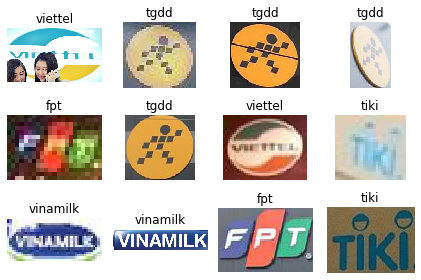

In [10]:
def visualize_some_samples(df, num_samples=20, save_fig_path=None):    
    num_samples = min(len(df), num_samples) # in case data frame has less sample than num_samples
    
    if 0 < num_samples <= 5:
        figure, axes = plt.subplots(num_samples, 1, squeeze=False)
        sample_idxs = df.index
        axes = axes.squeeze(1)
    else:
        num_samples_per_row = 4
        num_samples = num_samples - (num_samples % num_samples_per_row)
        figure, axes = plt.subplots(num_samples // num_samples_per_row, num_samples_per_row)
        axes = axes.ravel()
    
    loader = LoadImage(IMG_DIR)
    img_sr = loader.fit_transform(df)
    
    samples = img_sr.sample(n=num_samples, replace=False)
    
    for i, img in enumerate(samples):
        axes[i].imshow(img)
        company, predict = df.loc[samples.index[i], 'Company'], None
        if 'predict' in df.columns:
            predict = df.loc[samples.index[i], 'predict']
            axes[i].set_title(f'{predict}/{company}')
        else:
            axes[i].set_title(f'{company}')
        axes[i].axis('off')
        
    figure.tight_layout()
    if save_fig_path is not None:
        plt.savefig(save_fig_path)
    plt.show()

visualize_some_samples(train_df, num_samples=12, save_fig_path='./images/original_samples.jpg')

# Đặc trưng HOG

Đặc trưng HOG (Histogram Of Gradient) được sử dụng khá phổ biến trong giai đoạn đầu (trước khi xuất hiện DeepLearning) trong bài toán phát hiện đối tượng (Object Detection) và nhận dạng đối tượng (Object Recognition). Có thể xem qua bài báo gốc tại [đây](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) với gần 30000 lượt citing từ năm 2005.

Ngoài ra, đặc trưng HOG không yêu cầu tính toán quá phức tạp và về mặt trực quan, đặc trưng HOG dễ *thông dịch* hơn. Tức là khi nhìn vào đặc trưng sau khi rút trích, ta có thể mường tượng được tại sao HOG được sử dụng phổ biến như vậy.

Và trên hết, thuật toán đã được cài đặt sẵn trong thư viện `sklearn-image` và nhóm chỉ gọi hàm để sử dụng mà không phải cài đặt lại :p

Khai báo lớp `HOGFeatureExtractor` kế thừa từ `BaseEstimator` và `TransformerMixin` để có các phương thức `fit`, `transform`. Đặc trưng bao gồm nhiều siêu tham số, như số pixel trong một cell và số cell trong 1 block, số orientation ... (chi tiết các tham số bạn có thể xem tại [đây](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog)).

Tuy nhiên để HOG hoạt động đối với ảnh đa dạng kích thước cần có bước resize ảnh (thì số chiều của đặc trưng sẽ như nhau), nhưng resize ảnh sẽ làm biến dạng nội dung bên trong, dẫn đến ảnh hưởng đến kết quả nhận dạng, do đó nhóm chọn kích thước ảnh resize gồm `HOG_ROWS` và `HOG_COLS` là 2 siêu tham số chính của mô hình.

Về siêu tham số của bản thân thuật toán nhóm chọn tham số `orientations` là số bin của histogram. Phạm vi giá trị của orientation là từ 0-179 (độ), do đó nếu số bin càng lớn thì càng chiếm bộ nhớ, càng có nhiều đặc trưng hơn. Còn các siêu tham số khác nhóm để mặc định của thư viện, lý do sẽ được trình bày vào cuối notebook, phần tổng kết

In [11]:
class HOGFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, hog_size=(64, 128), orientations=9):
        self.hog_size = hog_size
        self.orientations = orientations
        
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_sr, y=None):
        features = X_sr.apply(self.extract)
        return np.array(features.tolist())
    
    def extract(self, img: np.ndarray):
        resized_img = resize(img, self.hog_size, mode='constant')
        features = hog(image=resized_img, orientations=self.orientations)
        return features

Visualize một số ảnh đặc trưng HOG với `HOG_ROWS=64`, `HOG_COLS=128`, `orientations=9`

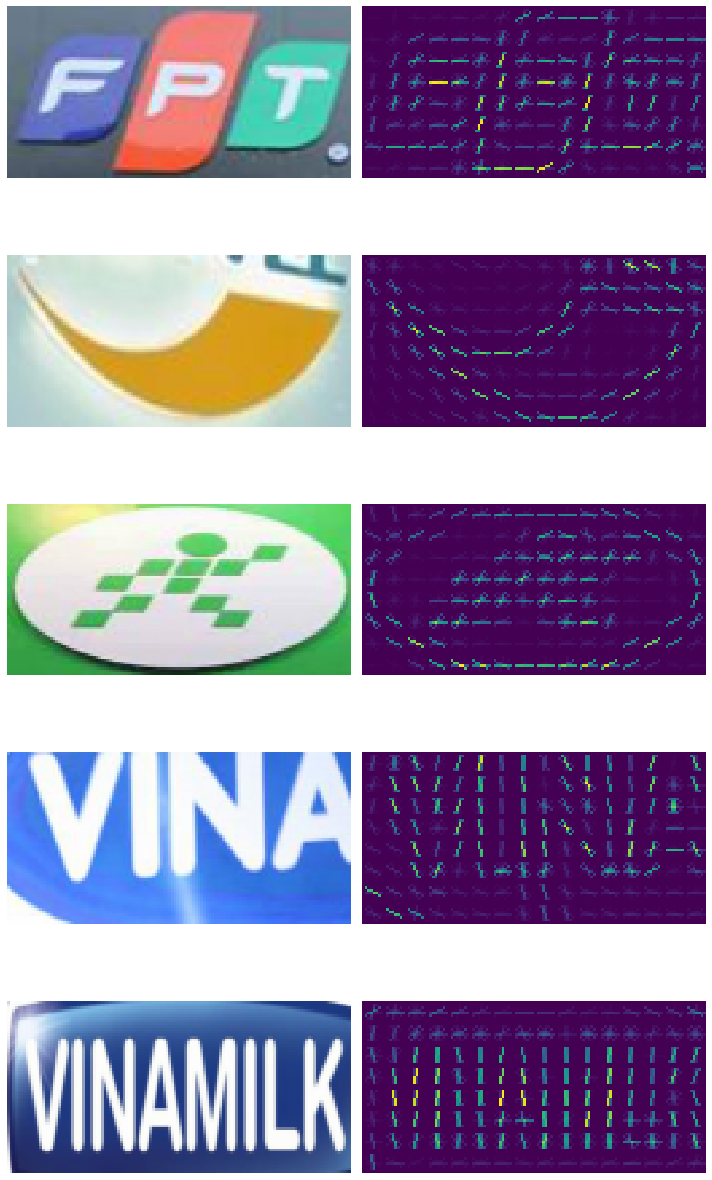

In [12]:
def visualize_some_samples_with_HOG(df, num_samples=5, HOG_ROWS=64, HOG_COLS=128, orientations=9, save_fig_path=None):
    num_samples = min(len(df), num_samples) # in case data frame has less sample than num_samples
    sample_idxs = np.random.choice(len(df), num_samples, replace=False)
    
    figure, axes = plt.subplots(num_samples, 2, figsize=(10,18))
    
    loader = LoadImage(IMG_DIR)
    img_sr = loader.fit_transform(df)
    for i, img in enumerate(img_sr.iloc[sample_idxs]):
        
        img = resize(img, (HOG_ROWS, HOG_COLS))
        
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        
        _, img_hog = hog(image=img, orientations=orientations, visualize=True)
        
        axes[i, 1].imshow(img_hog)
        axes[i, 1].axis('off')
        
    figure.tight_layout()
    if save_fig_path is not None:
        plt.savefig(save_fig_path)
    plt.show()

visualize_some_samples_with_HOG(train_df, num_samples=5, HOG_ROWS=64, HOG_COLS=128, orientations=9, save_fig_path='./images/original_hog_features.jpg')

# Xây dựng mô hình phân lớp áp dụng Machine Learning

Mô tả chung về workflow:
- **Giai đoạn 1**: Tiền xử lý dữ liệu - P1: Load ảnh từ tên file chứa trong DataFrame vào bộ nhớ
  - Input: dataframe gồm 2 cột là `['File name', 'Company']`
  - Output: Series chứa ảnh (mỗi ảnh là một `numpy.ndarray`)
- **Giai đoạn 2**: Tiền xử lý dữ liệu - P2: Rút trích đặc trưng HOG
  - Input: Series các ảnh
  - Output: `numpy.ndarray` 2D kích thước $M \times N$, trong đó:
    - Mỗi dòng của Output là đặc trưng HOG được rút trích ở ảnh ở dòng tương ứng ở Input
    - Số lượng cột tùy thuộc vào 2 siêu tham số `HOG_ROWS` và `HOG_COLS` và các siêu tham số của thuật toán HOG, nhưng sẽ giống nhau ở mỗi ảnh, tức là dù ảnh có kích thước khác nhau nhưng số chiều của vector đặc trưng là như nhau (do đã resize về cùng 1 kích thước)
- **Giai đoạn 3**: Tiền xử lý dữ liệu - P3: Normalize đặc trưng - StandardScaler
  - Input: `numpy.ndarray` 2D kích thước $M \times N$ với $M$ là số lượng ảnh và $N$ là kích thước của vector đặc trưng
  - Output: `numpy.ndarray` 2D kích thước $M \times N$ với các giá trị được chuẩn hóa về cùng khoảng giá trị
  - **Lưu ý**: Nhóm không xử lý giá trị thiếu, do mỗi dòng của dataframe tương ứng với 1 ảnh, thiếu giá trị tức là thiếu hẳn 1 bức ảnh. Nhưng nếu đã có ảnh tức là sẽ rút đặc trưng được và thuật toán HOG đảm bảo sẽ rút được đặc trưng và đặc trưng này đảm bảo không có giá trị thiếu.
- **Giai đoạn 4**: Huấn luyện mô hình
  - Input: `numpy.ndarray` 2D kích thước $M \times N$
  - Output: `numpy.ndarray` 1D kích thước $M \times 1$ là $M$ lớp tương ứng với $M$ đặc trưng
  
Toàn bộ workflow được thể hiện qua pipeline `full_pipeline`

In [13]:
full_pipeline = Pipeline([
    ('load_image', LoadImage()),
    ('extract_feature', HOGFeatureExtractor()),
    ('normalize', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), 
                                 solver='lbfgs', 
                                 random_state=RANDOM_SEED))
])

Chạy thử trên tập huấn luyện

In [14]:
def get_raw_X_Y(df: pd.DataFrame):
        return df[['File name']], df['Company']

In [15]:
def run(pipeline: Pipeline, raw_X, raw_Y, hyper_params_dict: dict = None, is_train=True):
    if hyper_params_dict is not None:
        pipeline.set_params(**hyper_params_dict)
    
    if is_train:
        pipeline.fit(raw_X, raw_Y)
    
    loss = (1-pipeline.score(raw_X, raw_Y))
    return loss

In [16]:
def try_train(pipeline, df):
    train_raw_X, train_raw_Y = get_raw_X_Y(df)
    loss = run(full_pipeline, train_raw_X, train_raw_Y, None, True) # use default hyper params
    print(f'Train loss: {loss}')
try_train(full_pipeline, train_df)

Train loss: 0.0


Chạy thử trên tập validation

In [17]:
def try_val(pipeline, df):
    val_raw_X, val_raw_Y = get_raw_X_Y(df)
    loss = run(pipeline, val_raw_X, val_raw_Y, None, False) # use default hyper params
    print(f'Validation loss: {loss}')
try_val(full_pipeline, val_df)

Validation loss: 0.04761904761904767


# Tối ưu tham số mô hình

In [18]:
def search_params(pipeline, train_df, val_df, params, verbose=True):
    train_raw_X, train_raw_Y = get_raw_X_Y(train_df)
    val_raw_X, val_raw_Y = get_raw_X_Y(val_df)
    
    logger = []
    for i, param in enumerate(params):
        print(f'[{i+1}]/[{len(params)}]')
        if verbose:
            print(param)
            
        start_train = time.time()
        train_loss = run(pipeline, train_raw_X, train_raw_Y, param, is_train=True)
        train_elapsed = time.time() - start_train
        print(f'\tTrain time: {train_elapsed:3.2f} - Train Loss: {train_loss}')
        
        start_val = time.time()
        val_loss = run(pipeline, val_raw_X, val_raw_Y, param, is_train=False)
        val_elapsed = time.time() - start_val
        print(f'\tValidation time: {val_elapsed:3.2f} - Validation Loss: {val_loss}')
        
        logger.append({
            'index': i,
            'param': param,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_time': train_elapsed,
            'val_time': val_elapsed
        })
        
    return logger

In [19]:
def get_params_to_try(small=False):
    hog_sizes = [(64, 128), (32, 64)]
    alphas = [0, 0.1, 1, 10]
    orientations = [1, 3, 9, 18]

    params = [{
        'extract_feature__hog_size': hog_size,          # thử thay đổi kích thước HOG
        'extract_feature__orientations': orientation,   # thử thay đổi số bin
        'classifier__alpha': alpha,                     # thử thay đổi tham số weight_decay
    }
        for hog_size in hog_sizes 
        for alpha in alphas
        for orientation in orientations
    ]
    
    if small:
        indexes = np.random.choice(len(params), min(len(params), 5))
        params = np.array(params)[indexes]
    return params

In [20]:
large_params = get_params_to_try()
len(large_params)

32

In [21]:
logger = search_params(full_pipeline, train_df, val_df, large_params)

[1]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 1, 'classifier__alpha': 0}
	Train time: 3.58 - Train Loss: 0.0
	Validation time: 0.59 - Validation Loss: 0.09523809523809523
[2]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 3, 'classifier__alpha': 0}
	Train time: 3.95 - Train Loss: 0.0
	Validation time: 0.60 - Validation Loss: 0.04761904761904767
[3]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 9, 'classifier__alpha': 0}
	Train time: 4.98 - Train Loss: 0.0
	Validation time: 0.61 - Validation Loss: 0.04761904761904767
[4]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 18, 'classifier__alpha': 0}
	Train time: 6.04 - Train Loss: 0.0
	Validation time: 0.66 - Validation Loss: 0.04761904761904767
[5]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 1, 'classifier__alpha': 0.1}
	Train time: 4.10 - Train Loss: 0.0
	Validation time: 0

In [22]:
tried_params_df = pd.DataFrame(logger)
tried_params_df.set_index('index', inplace=True)
tried_params_df = pd.concat([tried_params_df.drop(['param'], axis=1), tried_params_df['param'].apply(pd.Series)], axis=1)
tried_params_df = tried_params_df.rename({
    'extract_feature__hog_size': 'hog_size',
    'extract_feature__orientations': 'orientations',
    'classifier__alpha': 'alpha',
}, axis=1)
print(tried_params_df)
print(f'Trained in {tried_params_df["train_time"].sum():.2f}s and validated in {tried_params_df["val_time"].sum():.2f}s')
print(f'Total {np.sum(tried_params_df[["train_time", "val_time"]].values):.2f}s')

       train_loss  val_loss  train_time  val_time   hog_size  orientations  \
index                                                                        
0        0.000000  0.095238    3.576377  0.589221  (64, 128)             1   
1        0.000000  0.047619    3.949239  0.603563  (64, 128)             3   
2        0.000000  0.047619    4.984999  0.609166  (64, 128)             9   
3        0.000000  0.047619    6.043986  0.657239  (64, 128)            18   
4        0.000000  0.142857    4.100019  0.575856  (64, 128)             1   
5        0.000000  0.047619    5.042482  0.586685  (64, 128)             3   
6        0.000000  0.015873    9.034303  0.624719  (64, 128)             9   
7        0.000000  0.015873   13.887435  0.653313  (64, 128)            18   
8        0.000000  0.126984    4.377132  0.567114  (64, 128)             1   
9        0.000000  0.063492    5.626787  0.658892  (64, 128)             3   
10       0.000000  0.015873   10.140366  0.617341  (64, 128)    

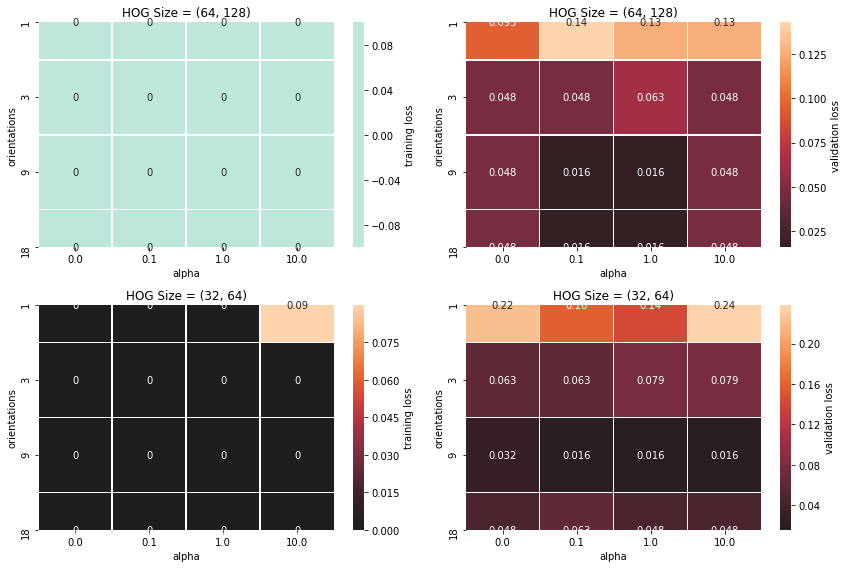

In [23]:
def visualize_training_log(params_df, save_fig_path=None):
    sizes = params_df['hog_size'].unique()
    assert len(sizes) == 2 # test
    fig, axes = plt.subplots(2,2, figsize=(12, 8))
    
    for i, size in enumerate(sizes):
        axes[i, 0].set_title(f'HOG Size = {size}')
        hog_size = params_df[params_df['hog_size'] == size]
        hog_size = hog_size.pivot('orientations', 'alpha', 'train_loss')
        sns.heatmap(hog_size, center=0, annot=True, linewidths=.5, ax=axes[i, 0], cbar_kws={'label': 'training loss'})
        
        axes[i, 1].set_title(f'HOG Size = {size}')
        hog_size = params_df[params_df['hog_size'] == size]
        hog_size = hog_size.pivot('orientations', 'alpha', 'val_loss')
        sns.heatmap(hog_size, center=0, annot=True, linewidths=.5, ax=axes[i, 1], cbar_kws={'label': 'validation loss'})

    fig.tight_layout()
    
    if save_fig_path is not None:
        plt.savefig(save_fig_path)
    plt.show()
    
visualize_training_log(tried_params_df, './images/original_training_heat_map.jpg')

In [24]:
def analyze_training_time(params_df):
    min_val_loss = params_df["val_loss"].min()
    print(f'Min validation loss = {min_val_loss}')
    print('Those best params are')
    best_params_df = params_df[params_df['val_loss'] == min_val_loss]
    analyze_df = best_params_df.drop(['train_loss', 'val_loss'], axis=1)
    analyze_df = analyze_df.sort_values(by=['train_time'], axis=0)
    print(analyze_df)
    
    return analyze_df.index[0]

my_best_param_index = analyze_training_time(tried_params_df)
print(f'I will choose param at index = {my_best_param_index}')

Min validation loss = 0.015873015873015928
Those best params are
       train_time  val_time   hog_size  orientations  alpha
index                                                      
22       2.461006  0.287827   (32, 64)             9    0.1
26       2.971911  0.270006   (32, 64)             9    1.0
30       3.507674  0.286749   (32, 64)             9   10.0
6        9.034303  0.624719  (64, 128)             9    0.1
10      10.140366  0.617341  (64, 128)             9    1.0
7       13.887435  0.653313  (64, 128)            18    0.1
11      15.129034  0.655166  (64, 128)            18    1.0
I will choose param at index = 22


Có thể thấy có khá nhiều siêu tham số dẫn đến cùng một kết quả, nhưng một số siêu tham số yêu cầu tính toán cao hơn, nên thời gian huấn luyện cũng lâu hơn. Do đó nhóm chọn siêu tham số tốt nhất dựa trên một tiêu chí nữa là thời gian huấn luyện

# Test

Sau khi huấn luyện và đánh giá trên tập train và validation tương ứng, nhóm chọn ra bộ siêu tham số tốt nhất có thể là:

In [25]:
best_params = logger[my_best_param_index]['param']
best_params

{'extract_feature__hog_size': (32, 64),
 'extract_feature__orientations': 9,
 'classifier__alpha': 0.1}

Huấn luyện trên tập train + validation

In [26]:
def last_learning(pipeline, best_params, train_df, val_df):
    combined_df = train_df.append(val_df)
    raw_X, raw_Y = get_raw_X_Y(combined_df)
    train_loss = run(pipeline, raw_X, raw_Y, best_params, is_train=True)
    print(f'Training Loss: {train_loss}')
    
last_learning(full_pipeline, best_params, train_df, val_df)

Training Loss: 0.0


Chạy trên tập kiểm tra

In [27]:
def test_pipeline(pipeline, test_df):
    raw_X, raw_Y = get_raw_X_Y(test_df)
    test_loss = run(full_pipeline, raw_X, raw_Y, None, is_train=False)
    print(f'Test Loss: {test_loss}')
    
test_pipeline(full_pipeline, test_df)

Test Loss: 0.015873015873015928


## Visualize một số sample nhận dạng sai

       File name Company   predict
17  logo_535.jpg    tgdd  vinamilk


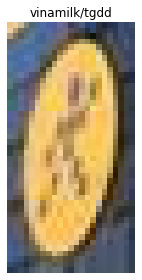

In [28]:
def visualize_wrong_predict(pipeline, test_df, save_fig_path=None):
    raw_X, raw_Y = get_raw_X_Y(test_df)
    predicts = pipeline.predict(raw_X)
    
    test_results_df = test_df.copy()
    test_results_df.loc[:, 'predict'] = predicts
    
    wrong_predicts = test_results_df[raw_Y != predicts]
    print(wrong_predicts)
    
    visualize_some_samples(wrong_predicts, save_fig_path=save_fig_path)
visualize_wrong_predict(full_pipeline, test_df, './images/augmentation_wrong_predicts.png')

# Thử với bộ dữ liệu sau khi augmentation

Có thể do bộ dataset mà nhóm thu thập còn khá đơn giản và ít nên mô hình nhận dạng sai rất ít. Bây giờ nhóm sẽ thử với tập dữ liệu đã augmentation

In [29]:
aug_train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
aug_val_df = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'))
aug_test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

Xem thông tin tập huấn luyện

In [30]:
aug_train_df.head()

,File name,Company
0,logo_1375.jpg,vinamilk
1,logo_965.png,viettel
2,logo_560.jpg,tgdd
3,logo_1070.jpg,vinamilk
4,logo_1145.png,vinamilk


In [31]:
aug_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
File name    1305 non-null object
Company      1305 non-null object
dtypes: object(2)
memory usage: 20.5+ KB


In [32]:
aug_train_df.describe()

,File name,Company
count,1305,1305
unique,1305,5
top,augmented_logos/logo_1274.jpg,vinamilk
freq,1,305


Visualize một số mẫu trong tập huấn luyện

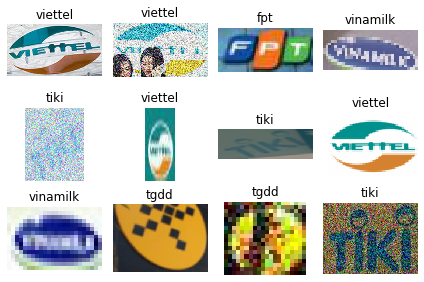

In [33]:
visualize_some_samples(aug_train_df, num_samples=12, save_fig_path='./images/augmentation_samples.jpg')

Visualize một số ảnh đặc trưng HOG với `HOG_ROWS=64`, `HOG_COLS=128`, `orientations=9`

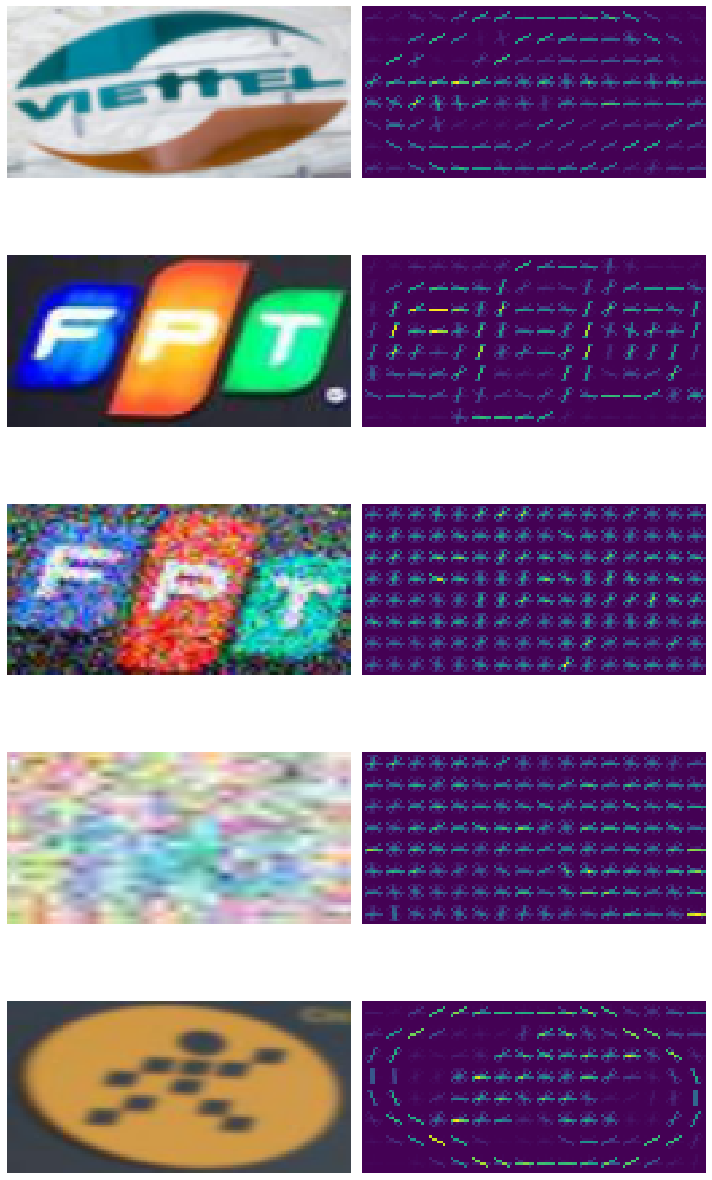

In [34]:
visualize_some_samples_with_HOG(aug_train_df, num_samples=5, HOG_ROWS=64, HOG_COLS=128, orientations=9, save_fig_path='./images/augmentation_hog_features.jpg')

# Xây dựng mô hình phân lớp áp dụng Machine Learning

Chạy thử trên tập huấn luyện

In [35]:
try_train(full_pipeline, aug_train_df)

Train loss: 0.0


Chạy thử trên tập validation

In [36]:
try_val(full_pipeline, aug_val_df)

Validation loss: 0.07586206896551728


## Tối ưu siêu tham số mô hình

In [37]:
aug_logger = search_params(full_pipeline, aug_train_df, aug_val_df, large_params)

[1]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 1, 'classifier__alpha': 0}
	Train time: 32.64 - Train Loss: 0.03524904214559388
	Validation time: 4.38 - Validation Loss: 0.2666666666666667
[2]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 3, 'classifier__alpha': 0}
	Train time: 28.08 - Train Loss: 0.0
	Validation time: 4.45 - Validation Loss: 0.08965517241379306
[3]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 9, 'classifier__alpha': 0}
	Train time: 31.01 - Train Loss: 0.0
	Validation time: 4.63 - Validation Loss: 0.07586206896551728
[4]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 18, 'classifier__alpha': 0}
	Train time: 35.36 - Train Loss: 0.0
	Validation time: 4.93 - Validation Loss: 0.07586206896551728
[5]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 1, 'classifier__alpha': 0.1}
	Train time: 31.27 - Train Loss: 0.0

In [38]:
aug_tried_params_df = pd.DataFrame(aug_logger)
aug_tried_params_df.set_index('index', inplace=True)
aug_tried_params_df = pd.concat([aug_tried_params_df.drop(['param'], axis=1), aug_tried_params_df['param'].apply(pd.Series)], axis=1)
aug_tried_params_df = aug_tried_params_df.rename({
    'extract_feature__hog_size': 'hog_size',
    'extract_feature__orientations': 'orientations',
    'classifier__alpha': 'alpha',
}, axis=1)
print(aug_tried_params_df)
print(f'Trained in {aug_tried_params_df["train_time"].sum():.2f}s and validated in {aug_tried_params_df["val_time"].sum():.2f}s')
print(f'Total {np.sum(aug_tried_params_df[["train_time", "val_time"]].values):.2f}s')

       train_loss  val_loss  train_time  val_time   hog_size  orientations  \
index                                                                        
0        0.035249  0.266667   32.641033  4.376869  (64, 128)             1   
1        0.000000  0.089655   28.082237  4.452493  (64, 128)             3   
2        0.000000  0.075862   31.011511  4.631182  (64, 128)             9   
3        0.000000  0.075862   35.357779  4.930490  (64, 128)            18   
4        0.037548  0.278161   31.269046  4.431226  (64, 128)             1   
5        0.000000  0.089655   28.194906  4.472554  (64, 128)             3   
6        0.000000  0.075862   30.632714  4.746387  (64, 128)             9   
7        0.000000  0.075862   35.371066  4.940802  (64, 128)            18   
8        0.039847  0.264368   31.082029  4.366631  (64, 128)             1   
9        0.000000  0.096552   31.952954  4.444923  (64, 128)             3   
10       0.000000  0.080460   43.304441  4.615431  (64, 128)    

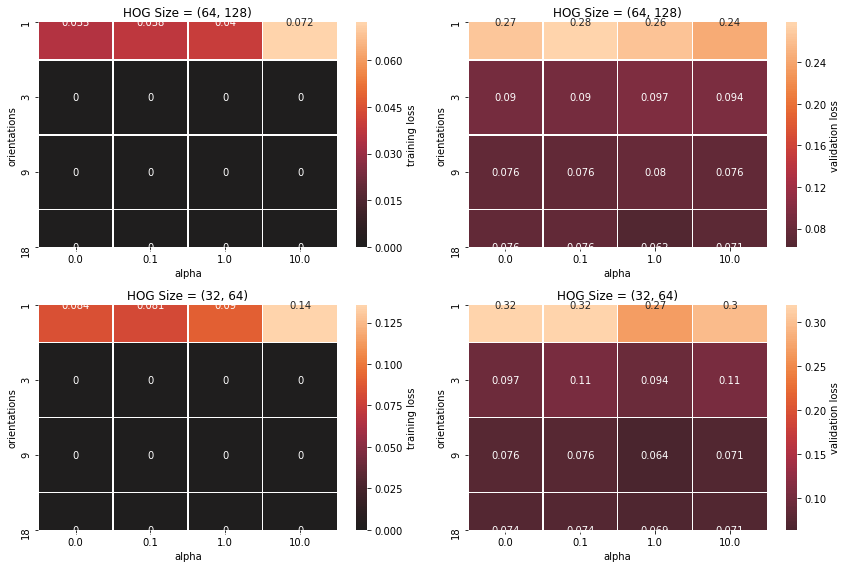

In [39]:
visualize_training_log(aug_tried_params_df, './images/augmentation_training_heat_map.jpg')

In [40]:
my_best_param_index_aug = analyze_training_time(aug_tried_params_df)
print(f'I will choose param at index = {my_best_param_index_aug}')

Min validation loss = 0.06206896551724139
Those best params are
       train_time  val_time   hog_size  orientations  alpha
index                                                      
11      56.955805  4.949105  (64, 128)            18    1.0
I will choose param at index = 11


## Test

Sau khi huấn luyện và đánh giá trên tập train và validation tương ứng, nhóm chọn ra bộ siêu tham số tốt nhất có thể là:

In [41]:
best_params_aug = aug_logger[my_best_param_index_aug]['param']
best_params_aug

{'extract_feature__hog_size': (64, 128),
 'extract_feature__orientations': 18,
 'classifier__alpha': 1}

Huấn luyện trên tập train + validation

In [42]:
last_learning(full_pipeline, best_params_aug, aug_train_df, aug_val_df)

Training Loss: 0.0


Chạy trên tập kiểm tra

In [43]:
test_pipeline(full_pipeline, aug_test_df)

Test Loss: 0.04137931034482756


## Visualize một số sample nhận dạng sai

                         File name   Company   predict
68     augmented_logos/logo_32.jpg       fpt      tiki
84    augmented_logos/logo_117.jpg       fpt      tiki
108   augmented_logos/logo_307.jpg       fpt      tiki
143   augmented_logos/logo_536.jpg      tgdd  vinamilk
145   augmented_logos/logo_538.jpg      tgdd  vinamilk
146   augmented_logos/logo_539.jpg      tgdd  vinamilk
208   augmented_logos/logo_932.jpg      tiki   viettel
224  augmented_logos/logo_1017.jpg   viettel      tiki
228  augmented_logos/logo_1047.jpg   viettel      tiki
244  augmented_logos/logo_1167.jpg  vinamilk      tiki
276  augmented_logos/logo_1322.jpg  vinamilk   viettel
300  augmented_logos/logo_1487.jpg  vinamilk      tgdd
360  augmented_logos/logo_2100.jpg   viettel      tiki
414  augmented_logos/logo_2154.jpg   viettel      tiki
416  augmented_logos/logo_2156.jpg   viettel      tiki
423  augmented_logos/logo_2163.jpg   viettel      tiki
426  augmented_logos/logo_2166.jpg   viettel      tiki
429  augme

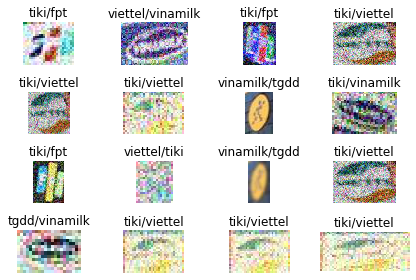

In [44]:
visualize_wrong_predict(full_pipeline, aug_test_df, './images/augmentation_wrong_predicts.png')